In [ ]:
from qtuum.api_wrappers import QuantinuumAPI as QAPI
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

from classical import overlap
from Loschmidt import loschmidt_paper
from optimisation import optimise, restartFromFail

C:\Users\lgover\Miniconda3\envs\qtuum\Lib\site-packages\scipy\integrate\_quadpack_py.py:575: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


## How it works
#### Optimise
Runs as: *optimise(machine,circuit_type,p0,p1,timestep,filename,shots=333)* </br></br>
Inputs:
- machine: 
    - for emulator: machine= 'H1-1E'
    - for actual hardware: machine = 'H1-1' or 'H1-2'?
- circuit_type:
    - for a single copy of the circuit per circuit: = 'single'
    - for two copies of the circuit per circuit: = 'double'
    - for three copies of the circuit per circuit: = 'triple'
- p0: the parameters from the previous time step (used to do the fitting)
- p1: the parameters for the current time step (to evolve from)
- timestep: which timestep is being evolved from
- filename: (type: str) the name of the file to save the data to incase of failure
- shots: number of shots of each circuit, default is set to 1000

#### restartFromFail
Runs as *restartFromFail(machine,p1,timestep,timestamp,filename, )* </br></br>
Inputs: (the same as for optimise but only need don't need the parameters from the timestep before as do not need to do a linear fit
- machine: 
    - for emulator: machine= 'H1-1E'
    - for actual hardware: machine = 'H1-1' or 'H1-2'?
- circuit_type:
    - for a single copy of the circuit per circuit: = 'single'
    - for two copies of the circuit per circuit: = 'double'
    - for three copies of the circuit per circuit: = 'triple'
- p1: the parameters for the timestep being evolved from **no longer need the one from the timestep before**
- timestep: which timestep is being evolved from
- filename: (type: str) the name of the file to save the data to incase of failure, and from which to recover the data from
- timestamp: (type: str) the associated timestamp outputted by the initial run of the optimisation (this will be printed when the optimise function is run)

</br>
Both will output the new updated parameters and shows a plot of the Loschmidt echo with this time evolution step plotted on it for comparison to check the evolution is progresssing correctly
</br>The files with the results which can be used to restart the SPSA optimisation are saved in the *results_data* folder

### Example Final Plot
Shows the exact Loschmidt echo (red), one produced by classical transfer matrix simulation (orange) and two example emulator runs (blue and cyan) as an example of what a successful run looks like

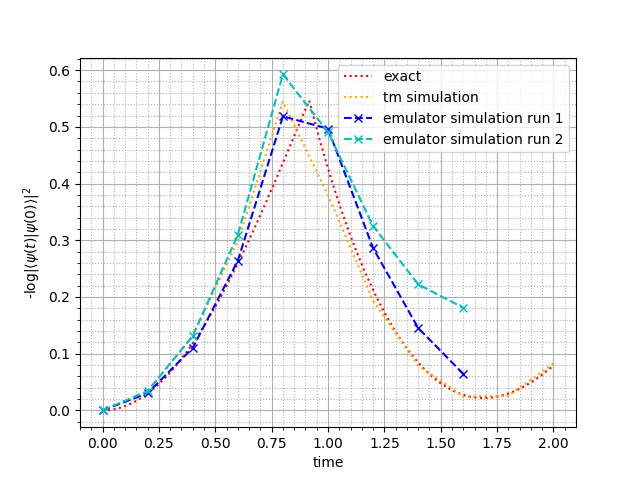

#### Generate exact Loschmidt echo

In [4]:
g0, g1 = 1.5, 0.2
max_time = 2
ltimes = np.linspace(0.0, max_time, 800)
correct_ls = [loschmidt_paper(t, g0, g1) for t in ltimes]

#### Transfer matrix (classical simulation data)

In [6]:
paramData = np.load('TMparams100000.npy')
x0 = paramData[0]
x1 = paramData[1]
x2 = paramData[2]
tm_losch = [overlap(x0,params) for params in paramData]

#### Choose which machine to use and check its online
**Currently set as emulator need to change to the actual device**

In [9]:
machine = 'H1-1E' # emulator = 'H1-1E', actual device = 'H1-1' or 'H1-2'
qapi = QAPI(machine) 
#print('Machine status:', qapi.machine, 'is', qapi.status()) # for checking emulator is online

Machine status: H1-1E is online


### Running the evolution

In [41]:
evolvedParams = [x0,x1,x2]

##### Timestep = 0.4

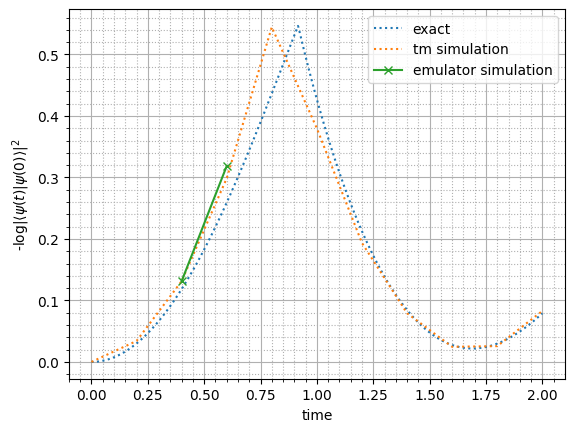

In [42]:
x3 = optimise(machine,'triple',x1,x2,0.4,filename='step04')
evolvedParams.append(x3)

In [1]:
### use this restart the evolution if in fails within one timestep
### fill in the associated timestamp
#x3 = restartFromFail(machine,'triple',x2,0.4,[TIMESTAMP],filename='step04')
#evolvedParams.append(x3)

##### Timestep = 0.6

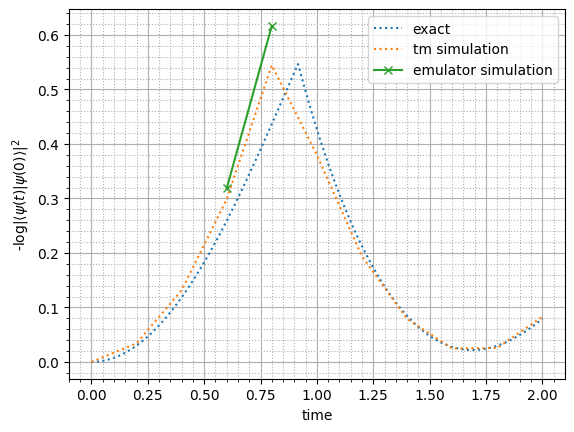

In [43]:
x4 = optimise(machine,'triple',x2,x3,0.6,filename='step06')
evolvedParams.append(x4)

In [2]:
#x4 = restartFromFail(machine,'triple',x3,0.6,[TIMESTAMP],filename='step06')
#evolvedParams.append(x4)

##### Timestep = 0.8

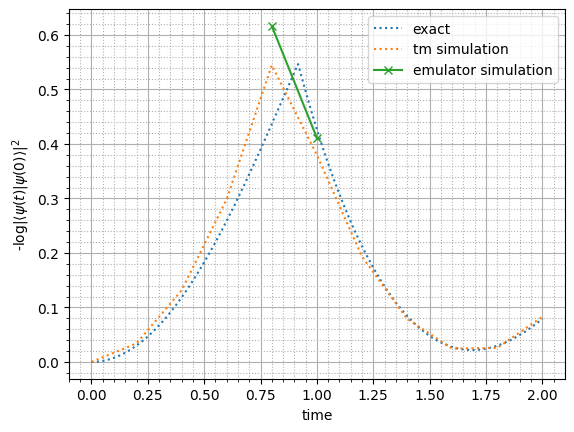

In [44]:
x5 = optimise(machine,'triple',x3,x4,0.8,filename='step08')
evolvedParams.append(x5)

In [3]:
#x5 = restartFromFail(machine,'triple',x4,0.8,[TIMESTAMP],filename='step08')
#evolvedParams.append(x5)

##### Timestep = 1

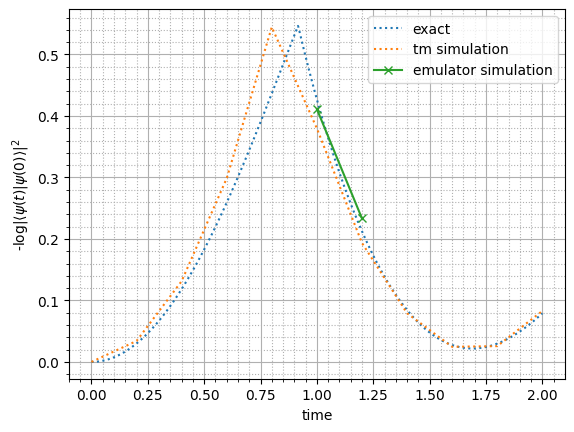

In [45]:
x6 = optimise(machine,'triple',x4,x5,1,filename='step10')
evolvedParams.append(x6)

In [4]:
#x6 = restartFromFail(machine,'triple',x5,1,[TIMESTAMP],filename='step10')
#evolvedParams.append(x6)

##### Timestep = 1.2

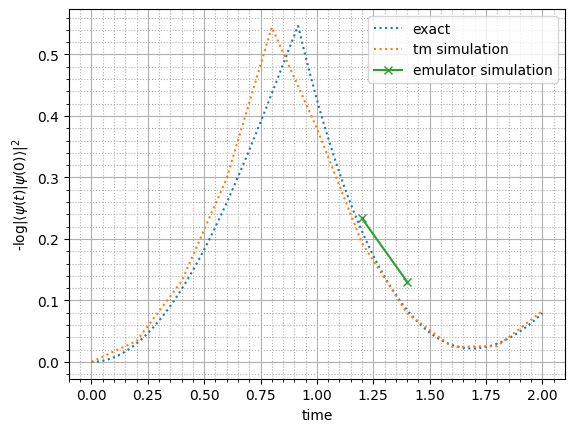

In [46]:
x7 = optimise(machine'triple',x5,x6,1.2,filename='step12')
evolvedParams.append(x7)

In [5]:
#x7 = restartFromFail(machine,'triple',x6,1.2,[TIMESTAMP],filename='step12')
#evolvedParams.append(x7)

##### Timestep = 1.4

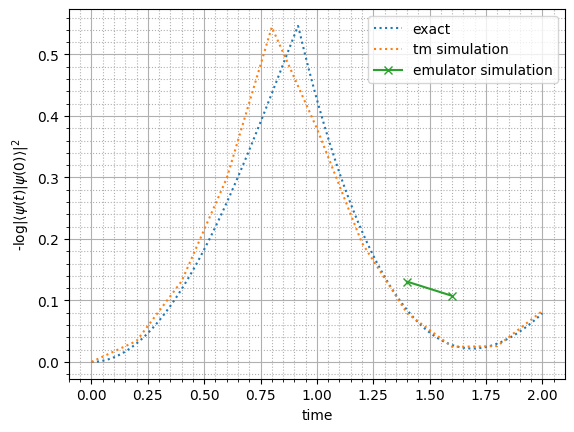

In [47]:
x8 = optimise(machine,'triple',x6,x7,1.4,filename='step14')
evolvedParams.append(x8)

In [ ]:
#x8 = restartFromFail(machine,'triple',x7,1.4,[TIMESTAMP],filename='step14')
#evolvedParams.append(x8)

## Final Plot

In [53]:
np.save('final_data/parameter_results.npy',evolvedParams)
losch_values = [overlap(x0,param) for param in evolvedParams]
np.save('final_data/loschmidt_echo_results.npy',losch_values)

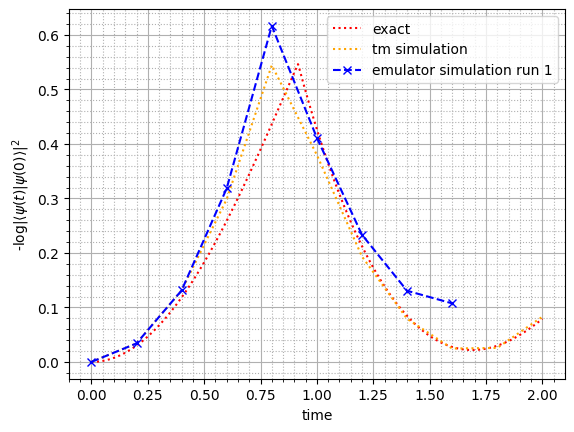

In [54]:
plt.plot(ltimes,correct_ls, ls = ':', c='r', label = 'exact')
plt.plot([0.2*i for i in range(len(tm_losch))],-np.log(tm_losch), ls = ':', c= 'orange', label = 'tm simulation')
plt.plot([0.2*i for i in range(len(losch_values))],-np.log(losch_values), label = 'emulator simulation run 1', marker = 'x', ls = '--', c='b')

plt.xlim(-0.1,2.1)
plt.legend()
plt.xlabel('time')
plt.ylabel(r'-log$|\langle\psi(t)|\psi(0)\rangle|^2$')
plt.minorticks_on()
plt.grid(True, which='major')
plt.grid(True, which='minor', ls = ':')
plt.savefig('final_data/loschmidtEcho.png')
plt.show()